# G3 Cell Counting Analysis

From 27,462 raw images spanning several different treatment conditions (denoted as "colors") as well as flow regimes (aka pumping methods)

### Initialization

In [1]:
config_path = '/lab/repos/celldom/config/experiment/exp-20180614-G3-K562-imatinib-poc-01.yaml'
#data_dir = '/lab/data/celldom/output/20180908-G3-full'
data_dir = '/lab/data/celldom/output/20181005-G3-full'

In [2]:
# %load ../../plotly.py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode()

In [3]:
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
from celldom.config import experiment_config
import celldom
import glob
import plotnine as pn
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from celldom.core import cytometry
from celldom.core import modeling
from celldom.execute import analysis

## EDA

In [4]:
config = experiment_config.ExperimentConfig(config_path)

In [5]:
# Open read-only connection to datastore containing result tables
store = cytometry.get_readonly_datastore(data_dir)

In [6]:
cell_data = store.get('cell')
len(cell_data)

189014

In [7]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189014 entries, 0 to 0
Data columns (total 25 columns):
acq_apartment       189014 non-null object
acq_cohort          189014 non-null object
acq_color           189014 non-null object
acq_condition       189014 non-null object
acq_datetime        189014 non-null datetime64[ns]
acq_hours           189014 non-null object
acq_id              189014 non-null object
acq_processed_at    189014 non-null datetime64[ns]
acq_pump            189014 non-null object
acq_street          189014 non-null object
apt_id              189014 non-null int64
apt_num             189014 non-null object
area                189014 non-null int64
cell_id             189014 non-null int64
centroid_x          189014 non-null float64
centroid_y          189014 non-null float64
eccentricity        189014 non-null float64
in_chamber          189014 non-null bool
roi_xmax            189014 non-null int64
roi_xmin            189014 non-null int64
roi_ymax            18

In [8]:
apt_data = store.get('apartment')

In [9]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52372 entries, 0 to 5
Data columns (total 37 columns):
acq_apartment             52372 non-null object
acq_cohort                52372 non-null object
acq_color                 52372 non-null object
acq_condition             52372 non-null object
acq_datetime              52372 non-null datetime64[ns]
acq_hours                 52372 non-null object
acq_id                    52372 non-null object
acq_processed_at          52372 non-null datetime64[ns]
acq_pump                  52372 non-null object
acq_street                52372 non-null object
apt_id                    52372 non-null int64
apt_image_height          52372 non-null int64
apt_image_width           52372 non-null int64
apt_num                   52372 non-null object
apt_num_digit_scores      52372 non-null object
cell_area_mean            42343 non-null float64
cell_area_p10             42343 non-null float64
cell_area_p50             42343 non-null float64
cell_area_p90  

In [9]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136729 entries, 0 to 5
Data columns (total 37 columns):
acq_apartment             136729 non-null object
acq_cohort                136729 non-null object
acq_color                 136729 non-null object
acq_condition             136729 non-null object
acq_datetime              136729 non-null datetime64[ns]
acq_hours                 136729 non-null object
acq_id                    136729 non-null object
acq_processed_at          136729 non-null datetime64[ns]
acq_pump                  136729 non-null object
acq_street                136729 non-null object
apt_id                    136729 non-null int64
apt_image_height          136729 non-null int64
apt_image_width           136729 non-null int64
apt_num                   136729 non-null object
apt_num_digit_scores      136729 non-null object
cell_area_mean            120114 non-null float64
cell_area_p10             120114 non-null float64
cell_area_p50             120114 non-null floa

### EDA

In [10]:
df = apt_data.copy()
df = analysis.add_experiment_date_groups(df, config.experimental_condition_fields)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136729 entries, 0 to 136728
Data columns (total 40 columns):
acq_apartment             136729 non-null object
acq_cohort                136729 non-null object
acq_color                 136729 non-null object
acq_condition             136729 non-null object
acq_datetime              136729 non-null datetime64[ns]
acq_hours                 136729 non-null object
acq_id                    136729 non-null object
acq_processed_at          136729 non-null datetime64[ns]
acq_pump                  136729 non-null object
acq_street                136729 non-null object
apt_id                    136729 non-null int64
apt_image_height          136729 non-null int64
apt_image_width           136729 non-null int64
apt_num                   136729 non-null object
apt_num_digit_scores      136729 non-null object
cell_area_mean            120114 non-null float64
cell_area_p10             120114 non-null float64
cell_area_p50             120114 non-null

### Date Group Validation

In [11]:
dfdt = (
    df
    .assign(assigned_hours=df['acq_hours'].apply(lambda v: '{:03d}'.format(int(v))))
    .groupby(config.experimental_condition_fields + ['assigned_hours']).agg({'elapsed_hours': 'median'})
).reset_index()

dfdt.head()

acq_pump acq_color acq_condition acq_cohort assigned_hours  elapsed_hours
0  Elveflow    Orange             1      0.1uM            000       0.033333
1  Elveflow    Orange             1      0.1uM            021      21.666667
2  Elveflow    Orange             1      0.1uM            045      45.800000
3  Elveflow    Orange             1      0.1uM            073      74.333333
4  Elveflow    Orange             1      0.1uM            099     100.333333

In [12]:
iplot({
    'data': [
        {'x': g['assigned_hours'], 'y': g['elapsed_hours'], 'name': ':'.join(k), 'mode': 'lines'}
        for k, g in dfdt.groupby(dfdt.filter(regex='acq_').columns.tolist())
    ],
    'layout': {
        'xaxis': {'title': 'Assigned Hours'},
        'yaxis': {'title': 'Elapsed Hours'}
    }
})

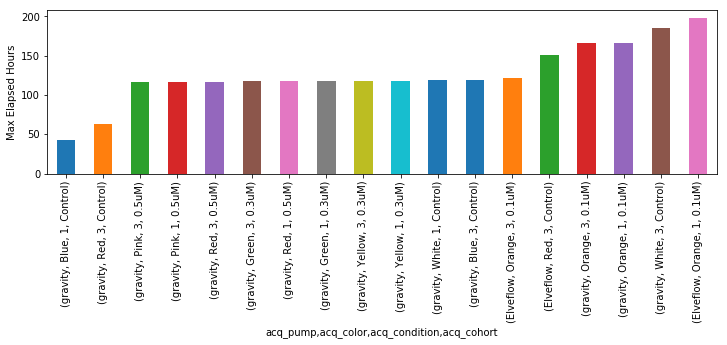

In [13]:
ax = dfdt.groupby(dfdt.filter(regex='acq_').columns.tolist())['elapsed_hours'].max()\
    .sort_values().plot(kind='bar', figsize=(12, 3))
ax.set_ylabel('Max Elapsed Hours')
None

#### Invalid Date Debugging

In [14]:
dfdt.set_index(dfdt.filter(regex='acq_').columns.tolist()).loc[
    ('gravity', 'White', '3', 'Control')
]

assigned_hours  elapsed_hours
acq_pump acq_color acq_condition acq_cohort                              
gravity  White     3             Control               000       0.033333
                                 Control               012      11.450000
                                 Control               021      20.250000
                                 Control               024      93.266667
                                 Control               036     109.116667
                                 Control               043      42.016667
                                 Control               048     118.150000
                                 Control               060     132.733333
                                 Control               072     142.016667
                                 Control               096     166.316667
                                 Control               120     185.733333

In [15]:
acq_data = store.get('acquisition')
acq_data = analysis.add_experiment_date_groups(acq_data, config.experimental_condition_fields, 3600)
acq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22880 entries, 0 to 22879
Data columns (total 18 columns):
acq_apartment             22880 non-null object
acq_cohort                22880 non-null object
acq_color                 22880 non-null object
acq_condition             22880 non-null object
acq_datetime              22880 non-null datetime64[ns]
acq_hours                 22880 non-null object
acq_id                    22880 non-null object
acq_processed_at          22880 non-null datetime64[ns]
acq_pump                  22880 non-null object
acq_street                22880 non-null object
apt_count                 22880 non-null int64
raw_image_path            22880 non-null object
raw_image_shape_height    22880 non-null int64
raw_image_shape_width     22880 non-null int64
rotation                  22880 non-null float64
elapsed_hours             22880 non-null float64
acq_datetime_group        22880 non-null datetime64[ns]
elapsed_hours_group       22880 non-null float64
dty

In [16]:
dft = acq_data.set_index(dfdt.filter(regex='acq_').columns.tolist()).sort_index().loc[
    ('gravity', 'White', '3', 'Control')
]
dft['acq_hours'] = dft['acq_hours'].astype(int)

def examples(g):
    g = g.sort_values('acq_datetime')
    g['filename'] = g['raw_image_path'].str.split('/').str[-1]
    return g[['acq_datetime', 'filename', 'elapsed_hours']].head(2)
dft = dft.groupby('acq_hours').apply(examples).reset_index()
dft['diff'] = (dft['acq_hours'].astype(int) - dft['elapsed_hours']).abs()
dft.style.background_gradient(subset='diff', high=.5)

In [17]:
acq_data[acq_data['raw_image_path'].str.contains('BFF_16X_St_000_Apt_000_201806150024.tif')]['raw_image_path'].iloc[0]

'/lab/data/celldom/dataset/dataset05/_2018.06.14 EXP SUM Control 0.1uM with 5mL gravity/2018.06.14 White 3 Control/2018.06.14 White 3 Control 0 hr/BFF_16X_St_000_Apt_000_201806150024.tif'

In [17]:
acq_data[acq_data['raw_image_path'].str.contains('BFF_16X_St_000_Apt_000_201806182139.tif')]['raw_image_path'].iloc[0]

'/lab/data/celldom/dataset/dataset05/_2018.06.17 EXP SUM Control 0.3uM 0.5uM with 5mL gravity/_2018.06.17 White 3 Control/_2018.06.17 White 3 Control 24 hr/BFF_16X_St_000_Apt_000_201806182139.tif'

- dataset05/_2018.06.14 EXP SUM Control 0.1uM with 5mL gravity/2018.06.14 White 3 Control/2018.06.14 White 3 Control **0 hr**/BFF_16X_St_000_Apt_000_**20180615**0024.tif

- dataset05/_2018.06.17 EXP SUM Control 0.3uM 0.5uM with 5mL gravity/_2018.06.17 White 3 Control/_2018.06.17 White 3 Control **24 hr**/BFF_16X_St_000_Apt_000_**20180618**2139.tif

### Cell Counts

In [19]:
import plotnine as pn

In [20]:
df = apt_data.copy()
df = analysis.add_experiment_date_groups(df, config.experimental_condition_fields)

In [21]:
df.set_index(config.experimental_condition_fields).sort_index()\
    .loc[('gravity', 'Orange', '3', '0.1uM')]['elapsed_hours_group'].value_counts().sort_index()

0.000000       870
11.666667      870
20.483333      858
42.266667      870
62.300000      858
83.933333      870
93.433333      870
109.183333     870
118.333333     870
132.866667     870
142.166667    1740
Name: elapsed_hours_group, dtype: int64

In [22]:
time_fields = ['acq_datetime_group', 'elapsed_hours_group']
addr_fields = ['apt_num', 'st_num']
dfp = df.groupby(config.experimental_condition_fields + time_fields + addr_fields)['cell_count'].median()
cols = dfp.index.names
dfp = dfp.reset_index()
dfp['group'] = dfp[[c for c in cols if c not in time_fields]].apply(lambda r: ':'.join(r), axis=1)
dfp.head()

acq_pump acq_color acq_condition acq_cohort  acq_datetime_group  \
0  Elveflow    Orange             1      0.1uM 2018-06-27 14:11:00   
1  Elveflow    Orange             1      0.1uM 2018-06-27 14:11:00   
2  Elveflow    Orange             1      0.1uM 2018-06-27 14:11:00   
3  Elveflow    Orange             1      0.1uM 2018-06-27 14:11:00   
4  Elveflow    Orange             1      0.1uM 2018-06-27 14:11:00   

   elapsed_hours_group apt_num st_num  cell_count  \
0                  0.0      00     00         2.0   
1                  0.0      00     01         3.0   
2                  0.0      00     02         3.0   
3                  0.0      00     03         3.0   
4                  0.0      00     04         2.0   

                           group  
0  Elveflow:Orange:1:0.1uM:00:00  
1  Elveflow:Orange:1:0.1uM:00:01  
2  Elveflow:Orange:1:0.1uM:00:02  
3  Elveflow:Orange:1:0.1uM:00:03  
4  Elveflow:Orange:1:0.1uM:00:04

In [23]:
dfp[dfp['group'].str.contains('gravity:Orange:3:0.1uM')]['elapsed_hours_group'].value_counts().sort_index()

0.000000      866
11.666667     859
20.483333     844
42.266667     870
62.300000     853
83.933333     860
93.433333     865
109.183333    868
118.333333    857
132.866667    867
142.166667    870
Name: elapsed_hours_group, dtype: int64

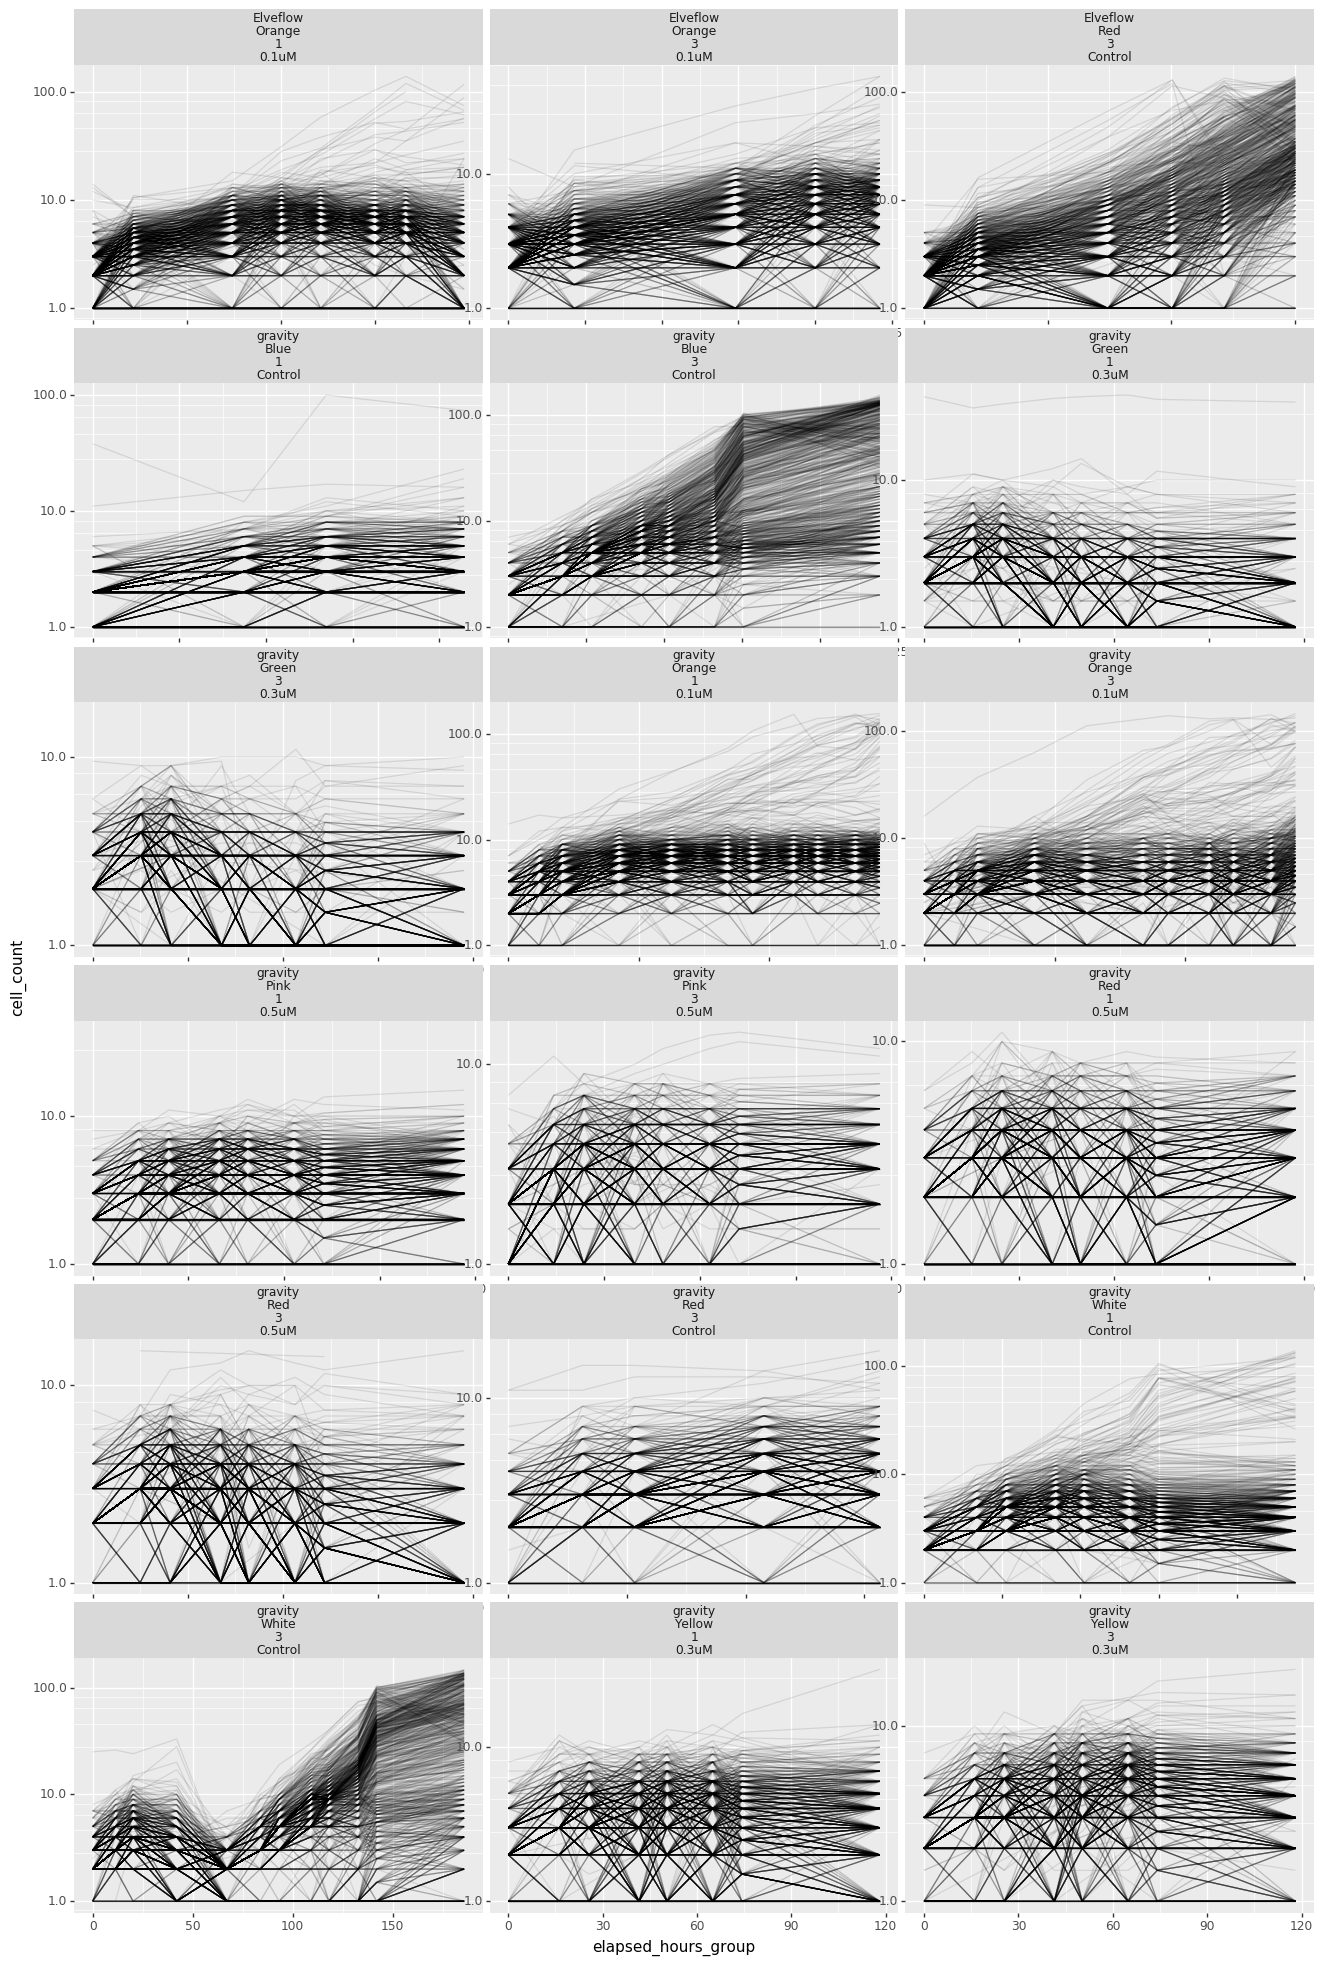

<ggplot: (8744990112299)>

In [24]:
(
    pn.ggplot(
        dfp.assign(cell_count=dfp['cell_count'] + 1), 
        pn.aes(x='elapsed_hours_group', y='cell_count', group='group')) +
    pn.geom_line(alpha=.1) +
    pn.guides(color=False) + 
    pn.scale_y_log10() +
    pn.facet_wrap('~' + '+'.join(config.experimental_condition_fields), ncol=3, scales='free') +
    pn.theme(figure_size=(16, 24))
)

In [ ]:
(
    pn.ggplot(dfp, pn.aes(x='elapsed_hours_group', y='cell_count', group='group')) +
    pn.geom_line(alpha=.1) +
    pn.guides(color=False) + 
    pn.facet_wrap('~' + '+'.join(config.experimental_condition_fields), ncol=3, scales='free') +
    pn.theme(figure_size=(16, 24))
)

In [63]:
def get_tzero_stats(g):
    g = g[g['cell_count'] > 0]
    return np.nan if len(g) == 0 else g['elapsed_hours_group'].min()
dfstat = dfp.groupby('group').apply(get_tzero_stats).rename('first_nz_hr').reset_index()
dfstat['array'] = dfstat['group'].apply(lambda v: ':'.join(v.split(':')[:-2]))

def classify(v):
    if pd.isnull(v):
        return 'Never'
    if v <= 24:
        return '<=24'
    if v <= 36:
        return '<=36'
    if v <= 48:
        return '<=48'
    return 'Late'
dfstat['first_nz_group'] = dfstat['first_nz_hr'].apply(classify)
dfstat.head()

group  first_nz_hr                    array  \
0  Elveflow:Orange:1:0.1uM:00:00          0.0  Elveflow:Orange:1:0.1uM   
1  Elveflow:Orange:1:0.1uM:00:01          0.0  Elveflow:Orange:1:0.1uM   
2  Elveflow:Orange:1:0.1uM:00:02          0.0  Elveflow:Orange:1:0.1uM   
3  Elveflow:Orange:1:0.1uM:00:03          0.0  Elveflow:Orange:1:0.1uM   
4  Elveflow:Orange:1:0.1uM:00:04          0.0  Elveflow:Orange:1:0.1uM   

  first_nz_group  
0           <=24  
1           <=24  
2           <=24  
3           <=24  
4           <=24

In [64]:
dfstat.groupby(['array', 'first_nz_group']).size().unstack().sort_values('Never').fillna(0).astype(int)

first_nz_group           <=24  <=36  <=48  Late  Never
array                                                 
gravity:White:3:Control   851     0     2    13      4
Elveflow:Red:3:Control    851     0     0    15      4
gravity:Blue:3:Control    824    11    10    28      6
gravity:White:1:Control   862     2     1     1      7
gravity:Red:3:0.5uM       802    10    45     6      8
gravity:Yellow:3:0.3uM    781    12    45    22     10
gravity:Orange:1:0.1uM    845     0    11     3     12
gravity:Yellow:1:0.3uM    818     5    20    11     16
gravity:Orange:3:0.1uM    824     0     5    20     21
Elveflow:Orange:3:0.1uM   843     0     0     8     21
gravity:Red:3:Control     847     0     2     1     29
gravity:Pink:3:0.5uM      803     0    13    14     44
gravity:Pink:1:0.5uM      808     0     8     6     48
Elveflow:Orange:1:0.1uM   793     0     0    18     55
gravity:Blue:1:Control    790    22     2     0     57
gravity:Green:3:0.3uM     791     6     1     2     57
gravity:Green:1:0.3uM     784     3     1     5     59
gravity:Red:1:0.5uM       775     5     2     0     73